In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def d(u, v):
    diff = u - v
    return diff.dot(diff)


In [8]:
def cost(X, R, M):
    cost = 0
    for k in range(len(M)):
        # method 1
        # for n in xrange(len(X)):
        #     cost += R[n,k]*d(M[k], X[n])

        # method 2
        diff = X - M[k]
        sq_distances = (diff * diff).sum(axis=1)
        cost += (R[:,k] * sq_distances).sum()
    return cost

In [9]:
def plot_k_means(X, K, max_iter=20, beta=1.0, show_plots=True):
    N, D = X.shape
    M = np.zeros((K, D))
    # R = np.zeros((N, K))
    exponents = np.empty((N, K))

    # initialize M to random
    for k in range(K):
        M[k] = X[np.random.choice(N)]

    costs = np.zeros(max_iter)
    for i in range(max_iter):
        # step 1: determine assignments / resposibilities
        # is this inefficient?
        for k in range(K):
            for n in range(N):
                # R[n,k] = np.exp(-beta*d(M[k], X[n])) / np.sum( np.exp(-beta*d(M[j], X[n])) for j in xrange(K) )
                exponents[n,k] = np.exp(-beta*d(M[k], X[n]))

        R = exponents / exponents.sum(axis=1, keepdims=True)
        # assert(np.abs(R - R2).sum() < 10e-10)

        # step 2: recalculate means
        for k in range(K):
            M[k] = R[:,k].dot(X) / R[:,k].sum()

        costs[i] = cost(X, R, M)
        if i > 0:
            if np.abs(costs[i] - costs[i-1]) < 10e-5:
                break

    if show_plots:
        plt.plot(costs)
        plt.title("Costs")
        plt.show()

        random_colors = np.random.random((K, 3))
        colors = R.dot(random_colors)
        plt.scatter(X[:,0], X[:,1], c=colors)
        plt.show()

    return M, R

In [10]:
def get_simple_data():
    # assume 3 means
    D = 2 # so we can visualize it more easily
    s = 4 # separation so we can control how far apart the means are
    mu1 = np.array([0, 0])
    mu2 = np.array([s, s])
    mu3 = np.array([0, s])

    N = 900 # number of samples
    X = np.zeros((N, D))
    X[:300, :] = np.random.randn(300, D) + mu1
    X[300:600, :] = np.random.randn(300, D) + mu2
    X[600:, :] = np.random.randn(300, D) + mu3
    return X

In [11]:
def main():
    X = get_simple_data()

    # what does it look like without clustering?
    plt.scatter(X[:,0], X[:,1])
    plt.show()

    K = 3 # luckily, we already know this
    plot_k_means(X, K)

    K = 5 # what happens if we choose a "bad" K?
    plot_k_means(X, K, max_iter=30)

    K = 5 # what happens if we change beta?
    plot_k_means(X, K, max_iter=30, beta=0.3)


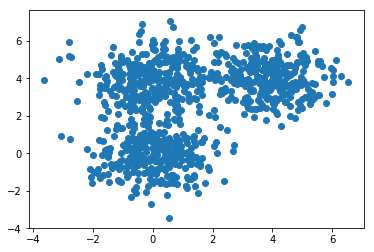

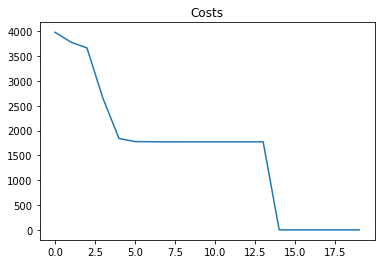

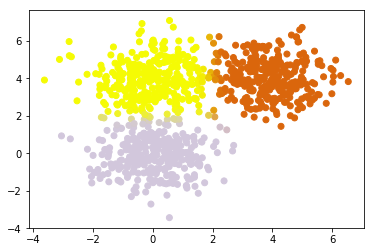

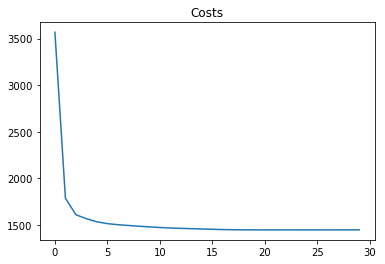

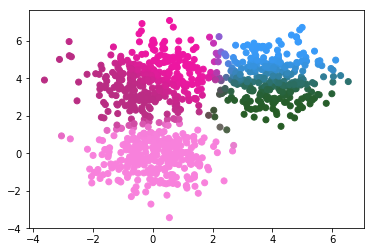

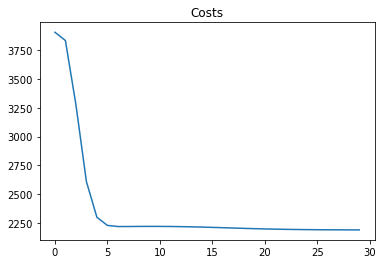

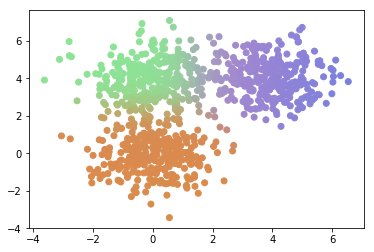

In [12]:
if __name__ == '__main__':
    main()

In [14]:
import pandas as pd
from datetime import datetime

In [16]:
def get_data(limit=None):
    print ("Reading in and transforming data...")
    df = pd.read_csv('../large_files/train.csv')
    data = df.as_matrix()
    np.random.shuffle(data)
    X = data[:, 1:] / 255.0 # data is from 0..255
    Y = data[:, 0]
    if limit is not None:
        X, Y = X[:limit], Y[:limit]
    return X, Y

In [21]:
def purity2(Y, R):
    # maximum purity is 1, higher is better
    C = np.argmax(R, axis=1) # cluster assignments

    N = len(Y) # number of data pts
    K = len(set(Y)) # number of labels

    total = 0.0
    for k in range(K):
        max_intersection = 0
        for j in range(K):
            intersection = ((C == k) & (Y == j)).sum()
            if intersection > max_intersection:
                max_intersection = intersection
        total += max_intersection
    return total / N

In [22]:
def purity(Y, R):
    # maximum purity is 1, higher is better
    N, K = R.shape
    p = 0
    for k in range(K):
        best_target = -1 # we don't strictly need to store this
        max_intersection = 0
        for j in range(K):
            intersection = R[Y==j, k].sum()
            if intersection > max_intersection:
                max_intersection = intersection
                best_target = j
        p += max_intersection
    return p / N

In [23]:
def DBI2(X, R):
    N, D = X.shape
    _, K = R.shape

    # get sigmas, means first
    sigma = np.zeros(K)
    M = np.zeros((K, D))
    assignments = np.argmax(R, axis=1)
    for k in range(K):
        Xk = X[assignments == k]
        M[k] = Xk.mean(axis=0)
        # assert(Xk.mean(axis=0).shape == (D,))
        n = len(Xk)
        diffs = Xk - M[k]
        sq_diffs = diffs * diffs
        sigma[k] = np.sqrt( sq_diffs.sum() / n )


    # calculate Davies-Bouldin Index
    dbi = 0
    for k in range(K):
        max_ratio = 0
        for j in range(K):
            if k != j:
                numerator = sigma[k] + sigma[j]
                denominator = np.linalg.norm(M[k] - M[j])
                ratio = numerator / denominator
                if ratio > max_ratio:
                    max_ratio = ratio
        dbi += max_ratio
    return dbi / K

In [24]:
def DBI(X, M, R):
    # ratio between sum of std deviations between 2 clusters / distance between cluster means
    # lower is better
    N, D = X.shape
    K, _ = M.shape

    # get sigmas first
    sigma = np.zeros(K)
    for k in range(K):
        diffs = X - M[k] # should be NxD
        squared_distances = (diffs * diffs).sum(axis=1) # now just N
        weighted_squared_distances = R[:,k]*squared_distances
        sigma[k] = np.sqrt( weighted_squared_distances.sum() / R[:,k].sum() )

    # calculate Davies-Bouldin Index
    dbi = 0
    for k in range(K):
        max_ratio = 0
        for j in range(K):
            if k != j:
                numerator = sigma[k] + sigma[j]
                denominator = np.linalg.norm(M[k] - M[j])
                ratio = numerator / denominator
                if ratio > max_ratio:
                    max_ratio = ratio
        dbi += max_ratio
    return dbi / K

In [26]:
def main():
    # mnist data
    X, Y = get_data(10000)

    # simple data
    # X = get_simple_data()
    # Y = np.array([0]*300 + [1]*300 + [2]*300)

    print ("Number of data points:", len(Y))
    M, R = plot_k_means(X, len(set(Y)))
    # Exercise: Try different values of K and compare the evaluation metrics
    print ("Purity:", purity(Y, R))
    print ("Purity 2 (hard clusters):", purity2(Y, R))
    print ("DBI:", DBI(X, M, R))
    print ("DBI 2 (hard clusters):", DBI2(X, R))

    # plot the mean images
    # they should look like digits
    for k in range(len(M)):
        im = M[k].reshape(28, 28)
        plt.imshow(im, cmap='gray')
        plt.show()


if __name__ == "__main__":
    main()

Reading in and transforming data...


FileNotFoundError: File b'../large_files/train.csv' does not exist